In [1]:
from pdf2image import convert_from_path
import os
import glob
import datetime

In [2]:
DATASET_PATH = '../data/dataset/'

In [3]:
all_files_paths = [
    x for x in glob.iglob(DATASET_PATH + '**', recursive=True)
    if os.path.isfile(x)
]

In [4]:
def convert_pdf_to_image(file_path, output_dir):
    
    images = convert_from_path(file_path)
    
    for i in range(len(images)):   
        images[i].save(os.path.join(output_dir, f'page{i}.jpg'), 'JPEG')

In [5]:
WORK_DIR = f'../data/result_{datetime.datetime.now().strftime("%d%m%Y_%H%m%s")}'
os.mkdir(WORK_DIR)

In [6]:
file_path = all_files_paths[-1]
output_dir = os.path.join(WORK_DIR, file_path.rsplit('/', 1)[1].rsplit('.', 1)[0])
os.mkdir(output_dir)

convert_pdf_to_image(file_path=file_path, output_dir=output_dir)

In [7]:
#import textract
#text = textract.process(file_path)
#text.decode('utf-8')

In [8]:
import cv2
import pytesseract
from pytesseract import Output

img = cv2.imread(os.path.join(output_dir, 'page0.jpg'))
custom_config = r'--oem 3 -l rus -c --tessdata-dir=/usr/local/share/tessdata/'

d = pytesseract.image_to_data(img, output_type=Output.DICT, config=custom_config)
print(d.keys())

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


In [9]:
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,

    Doc
)


segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)

In [10]:
def get_persons(text):
    doc = Doc(text)

    doc.segment(segmenter)
    #print(doc.tokens[:5])
    #print(doc.sents[:5])

    doc.tag_morph(morph_tagger)
    #print(doc.tokens[:5])
    #doc.sents[0].morph.print()

    for token in doc.tokens:
        token.lemmatize(morph_vocab)

    doc.parse_syntax(syntax_parser)
    #print(doc.tokens[:5])
    #doc.sents[0].syntax.print()

    doc.tag_ner(ner_tagger)
    #print(doc.spans[:5])
    #doc.ner.print()

    for span in doc.spans:
        span.normalize(morph_vocab)
    #print(doc.spans[:5])

    for span in doc.spans:
        if span.type == PER:
            span.extract_fact(names_extractor)
    
    return [(_.normal,  _.fact.as_dict, (_.start, _.stop))
            for _ in doc.spans if _.type == PER and _.fact]

In [11]:
text_combined_position2box_number = {}
text_combined = ''
curr_position = 0
for i, text in enumerate(d['text']):
    if text != '':
        for j in range(len(text)):
            text_combined_position2box_number[curr_position+j] = i
        text_combined += text
        curr_position += len(text)
        
        text_combined += ' '
        curr_position += 1

In [12]:
text_combined

'МЭР МОСКВЫ 1 РАСПОРЯЖЕНИЕ 12 июля 2016 г. № 475-РМ О возложении обязанностей Возложить исполнение обязанностей начальника Московской адми- нистративной дорожной инспекции с 12 июля 2016 г. на Сидорова Анд- рея Николаевича,  заместителя начальника Московской административ- ной дорожной инспекции.   С. С. Собянин Организационно- аналитическое управление Правительства — 2 Москвы     Подписано цифровой подписью: Департамент информационных технологий города Москвы '

In [13]:
# TODO " - " is the problem
#import re
#text_combined2 = re.sub(r'(\w)(- *)(\w)', r'\1\3', text_combined)
# TODO: rebuild text_combined_position2box_number after replace

In [14]:
persons = get_persons(text_combined)
persons

[('Сидоров Анд-', {'first': 'Сидоров', 'last': 'Анд'}, (192, 205)),
 ('С. С. Собянин',
  {'first': 'С', 'last': 'Собянин', 'middle': 'С'},
  (299, 312))]

In [15]:
boxes_num_to_show = set() 
for _, _, (i, j) in persons:
    for k in range(i, j+1):
        if k in text_combined_position2box_number:
            boxes_num_to_show.add(text_combined_position2box_number[k])

In [16]:
boxes_num_to_show

{43, 44, 63, 64, 65}

In [17]:
n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 0: # TODO check threshold
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        
        if i in boxes_num_to_show:
            c = (0, 0, 255)
        else:
            c = (0, 255, 0)
        
        img = cv2.rectangle(img, (x, y), (x + w, y + h), c, 2)


output_file = os.path.join(output_dir, 'page0_res.jpg')
cv2.imwrite(output_file, img)

True

In [18]:
cv2.imshow('img', img)

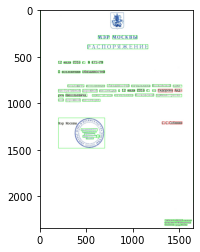

In [19]:
from matplotlib import pyplot as plt

image = cv2.imread(output_file)
image = image[:,:,::-1]
plt.imshow(image)